A quick python parser for the data from the excellent website https://energy-charts.info/index.html?l=en&c=UK

In [1]:
from functions.plot_prod import plot_prod

Matplotlib does not like the little legend hack we do in the plot_prod function, so we deactivate warnings.

In [2]:
import warnings
warnings.filterwarnings('ignore')

Single area graph with options for cumulative, rolling average, etc.
Pick country, year, and it plots the production (and load, if chosen).

https://energy-charts.info/charts/energy/data/fr/day_2021.json


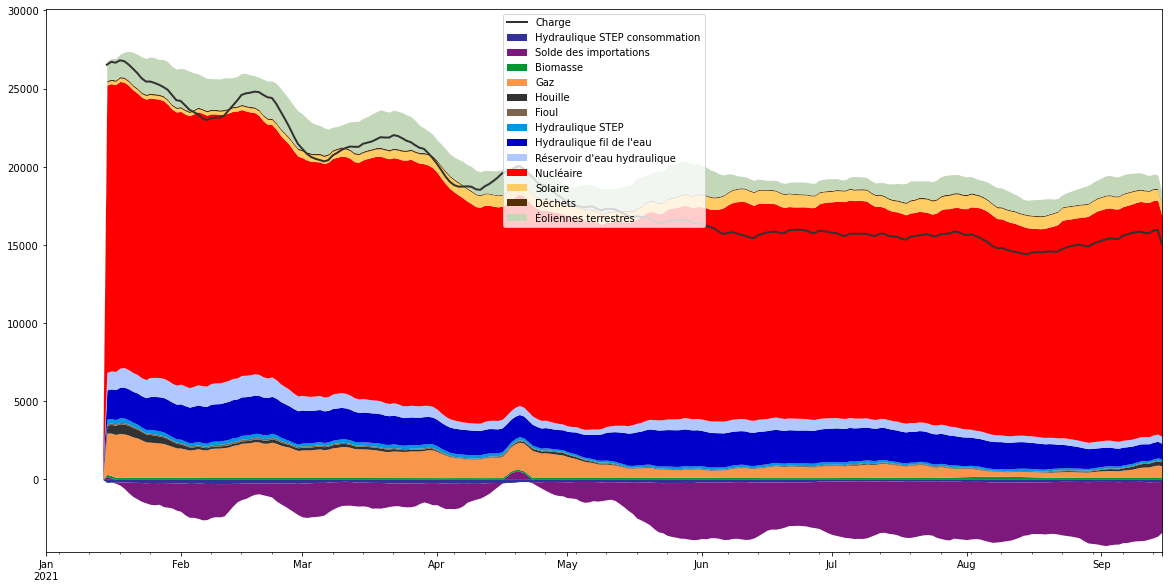

In [6]:
prod_df, load_df = plot_prod(country='fr', # country code
                             year='2021',  # year
                             display=True, # display chart (or just save data)
                             load=True,    # show load
                             cumul=False,  # cumulative
                             rolling=15,   # rolling average, in timesteps
                             lang='fr')    # language

For country comparison, you need to collect separate data and harmonise (labels are inconsistent).

In [17]:
all_prods = dict()

In [21]:
for country in ['de','it','fr','pl']:
    all_prods[country] = dict()
    for year in ['2019','2020','2021']: 
        all_prods[country][year], _ = plot_prod(country=country, year=year, display=False, load=False)

https://energy-charts.info/charts/energy/data/de/day_2019.json
https://energy-charts.info/charts/energy/data/de/day_2020.json
https://energy-charts.info/charts/energy/data/de/day_2021.json
https://energy-charts.info/charts/energy/data/it/day_2019.json
https://energy-charts.info/charts/energy/data/it/day_2020.json
https://energy-charts.info/charts/energy/data/it/day_2021.json
https://energy-charts.info/charts/energy/data/fr/day_2019.json
https://energy-charts.info/charts/energy/data/fr/day_2020.json
https://energy-charts.info/charts/energy/data/fr/day_2021.json
https://energy-charts.info/charts/energy/data/pl/day_2019.json
https://energy-charts.info/charts/energy/data/pl/day_2020.json
https://energy-charts.info/charts/energy/data/pl/day_2021.json


In [22]:
columns_agg = {'Hydro pumped storage consumption': 'Hydro pumped storage consumption',
               'Import Balance': 'Import balance',
               'Biomass': 'Biomass',
               'Fossil gas': 'Fossil gas',
               'Fossil oil': 'Fossil oil',
               'Hydro pumped storage': 'Hydro pumped storage generation',
               'Hydro Run-of-River': 'Hydro run-of-river',
               'Nuclear': 'Nuclear',
               'Others': 'Others',
               'Solar': 'Solar',
               'Waste': 'Waste',
               'Wind offshore': 'Wind',
               'Wind onshore': 'Wind',
               'Pumped Storage consumption': 'Hydro pumped storage consumption',
               'Hydro Power': 'Hydro',
               'Uranium': 'Nuclear',
               'Brown Coal': 'Brown coal',
               'Hard Coal': 'Hard coal',
               'Oil': 'Fossil oil',
               'Gas': 'Fossil gas',
               'Pumped Storage generation': 'Hydro pumped storage generation',
               'Wind': 'Wind',
               'Hydro Pumped Storage consumption': 'Hydro pumped storage consumption',
               'Fossil Brown Coal': 'Brown coal',
               'Fossil Hard Coal': 'Hard coal',
               'Fossil Oil': 'Fossil oil',
               'Fossil Gas': 'Fossil gas',
               'Hydro Pumped Storage generation': 'Hydro pumped storage generation',
               'Hydro Water Reservoir': 'Hydro',
               'Fossil hard coal': 'Hard coal'}

In [23]:
raw_agg = pd.concat([pd.concat(p, axis=0) for p in all_prods.values()], keys=all_prods.keys())
prod_agg = raw_agg.groupby(columns_agg, axis=1).sum()
prod_agg.index.names=('country','year','date')
prod_agg = prod_agg.reset_index()
prod_agg['day of year'] = prod_agg['date'].dt.dayofyear
prod_agg = prod_agg.drop('date',axis=1)
# prod_agg = prod_agg.drop('date')
prod_agg = prod_agg.set_index(['day of year','year','country']).unstack(['year','country'])
prod_agg = prod_agg.reorder_levels(order=[2,1,0],axis=1)
prod_agg['de','2019']*=1000

In [24]:
prod_agg[prod_agg==0] = np.nan

In [25]:
countries = prod_agg.columns.levels[0]
countries

Index(['de', 'dk', 'fr', 'it', 'pl'], dtype='object', name='country')

In [26]:
colors =  [ (r/255,g/255,b/255) for r,g,b in
           [
            (169,169,169), (128,128,128), (105,105,105),
             (102,102,255),(51,51,255),(0,0,255),
             (51,255,153),(0,255,128),(0,204,102),
            (255,128,0), (255,153,51) , (255,178,102),
               (238, 238, 105), (181, 179, 81), (157, 155, 71),
            (211, 52, 93), (231, 26, 47), (250, 0, 0),
           ]]


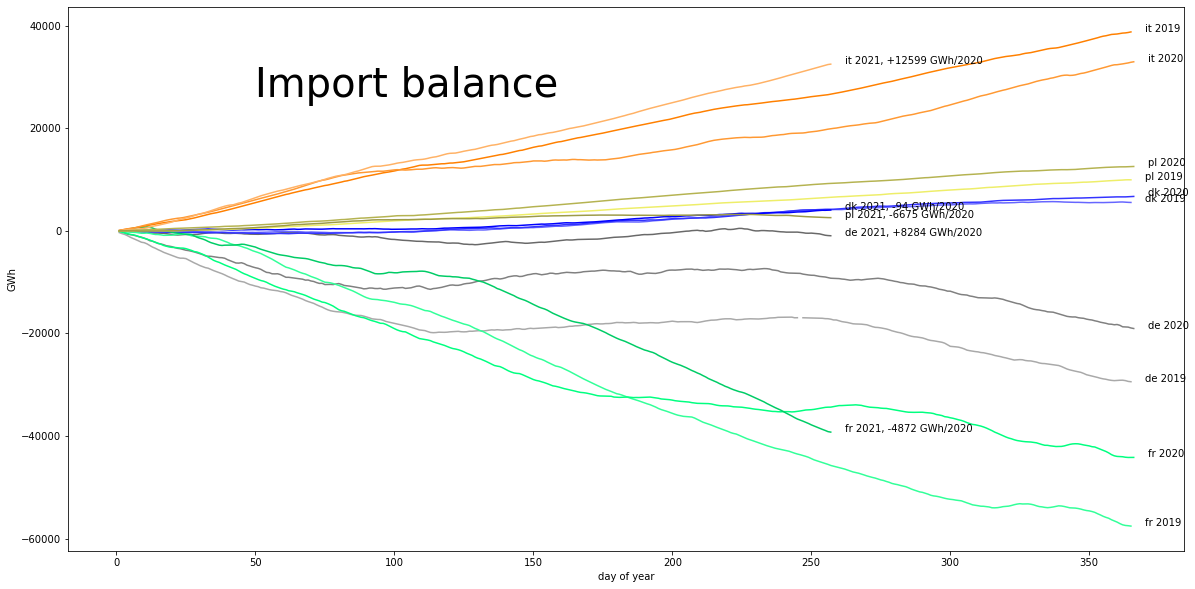

In [29]:
tech = 'Import balance'

cumul = prod_agg.loc[:,([c for c in countries if c not in ['es','be','nl']],slice(None),tech)].cumsum(skipna=True)
# cumul = cumul.groupby('year', axis=1).sum()
fig, ax = plt.subplots(figsize=(20,10), facecolor='w')

cumul.plot(color=colors, ax=ax)
for c in cumul.columns:
    last_v = cumul[c].last_valid_index()
    
    if c[1] == '2021':
        v_2020 = cumul.loc[last_v,(c[0], '2020', tech)]
        gap = cumul[c][last_v] - v_2020 
        label = f'{c[0]} {c[1]}, {gap:+0.0f} GWh/2020'
    else:
        label = f'{c[0]} {c[1]}'
        
    plt.text(cumul[c].last_valid_index() + 5,
             cumul[c][cumul[c].last_valid_index()],
             label)
plt.text(50, ax.get_ylim()[1] * .6, tech, fontsize=40)
ax.set_ylabel('GWh')
ax.get_legend().remove()